In [1]:
import jax
import jax.numpy as jnp
from chewc.population import quick_haplo
from chewc.sp import SimParam
from chewc.trait import add_trait_a
from chewc.phenotype import set_pheno
from chewc.cross import make_cross
from chewc.predict import gblup_predict
from chewc.population import combine_populations, Population
import matplotlib.pyplot as plt
from chewc.population import quick_haplo, combine_populations, Population, subset_population # Add subset_population


--- SETUP PHASE ---
Step 2.1: Creating founder population...
Step 2.2: Adding quantitative trait...
Step 2.3: Setting phenotypes for founders...
Founder population created with 100 individuals.

--- ESTABLISHMENT PHASE ---
Step 3.1: Selecting elite founders...
  Targeting 200 individuals from 25 crosses -> 8 offspring/cross.
Step 3.2: Generating training population...
Step 3.3: Phenotyping training population...
Training population created with 200 individuals.
Initial Genetic Variance (V_G_0) set to: 10.135

--- RECURRENT SELECTION LOOP ---

--- Generation 1 ---
  Training GBLUP model on 200 individuals...
  Selecting 50 parents based on GEBVs...
  Generating 125 candidates...
  Calculating true BVs for 125 candidates...
  Predicting GEBVs for 125 candidates...
  Selecting top 5 elites from candidates...
  Phenotyping elites with h2=0.5...
  Updating training population with new elites...
  Trimming training population to most recent 200 individuals...
  Generation 1 complete. Mean Tr

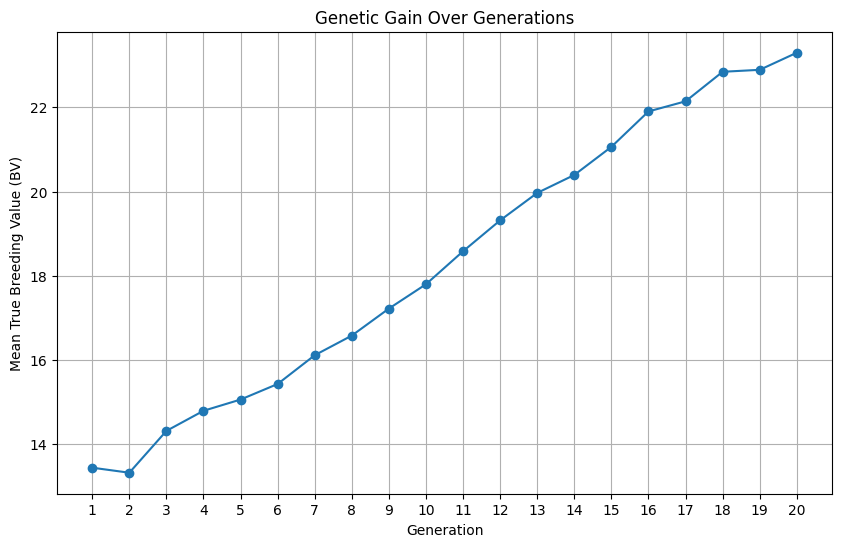

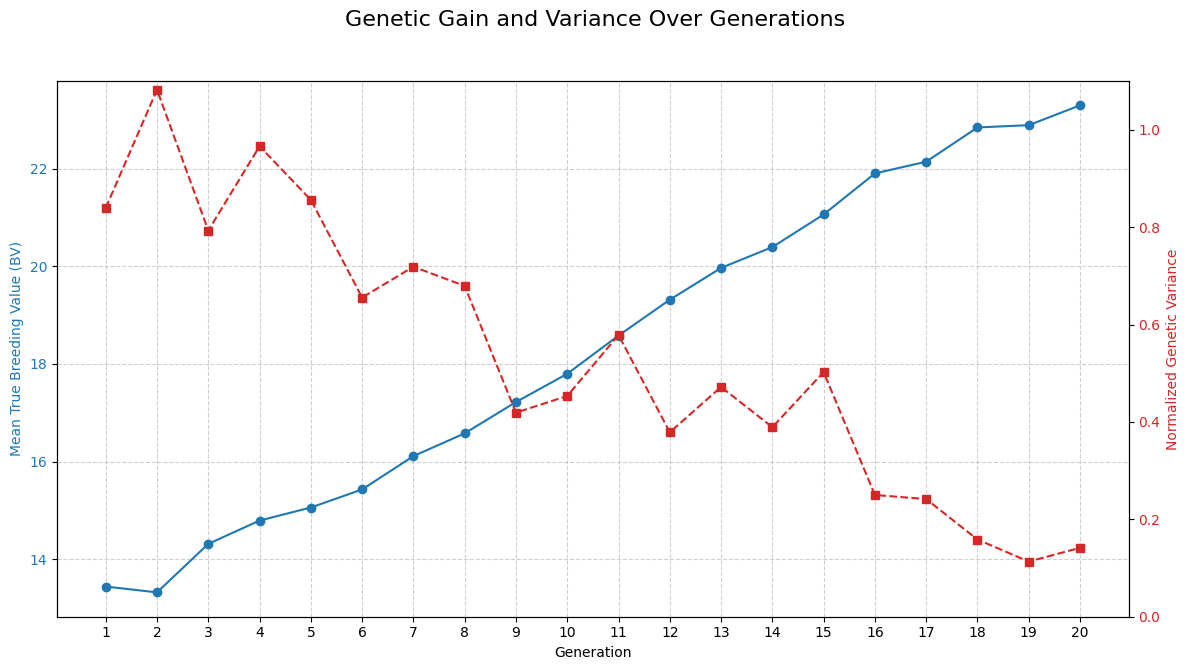

In [21]:
import jax
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt

# Import chewc library components
from chewc.population import quick_haplo, combine_populations, Population, subset_population
from chewc.sp import SimParam
from chewc.trait import add_trait_a
from chewc.phenotype import set_pheno, set_bv
from chewc.cross import make_cross
from chewc.predict import gblup_predict
# =============================================================================
# 1. SIMULATION CONFIGURATION
# =============================================================================
# All parameters are defined here for easy modification and reproducibility.
config = {
    "simulation": {
        "seed": 42,
        "n_generations": 20,
    },
    "founder": {
        "n_ind": 100,
        "n_chr": 5,
        "n_loci_per_chr": 200,
    },
    "trait": {
        "n_qtl_per_chr": 50,
        "mean": jnp.array([100.0]),
        "var": jnp.array([10.0]),
        # CHANGE 1: Increased heritability for a clearer signal
        "h2_initial": 0.5,
    },
    "breeding_program": {
        # --- Stage 1: Creating the Training Population ---
        "n_elite_founders": 10,
        "n_offspring_per_founder_cross": 5,
        "training_population_size": 200,
        
        # --- Stage 2: The Recurrent Selection Cycle ---
        "parent_selection_criterion": "ebv",
        "n_parents_per_generation": 50,
        # CHANGE 2: Adjusted offspring to create a standard 1000-candidate pool
        "n_offspring_per_cross": 5,
        # CHANGE 3: Increased elites to improve training data relevance
        "n_elite_selections_per_generation": 5, 
        "h2_elite_phenotyping": 0.5,
    }
}



# =============================================================================
# 2. SETUP PHASE: FOUNDER POPULATION AND TRAIT DEFINITION
# =============================================================================
print("--- SETUP PHASE ---")

# Initialize JAX random key
key = jax.random.PRNGKey(config["simulation"]["seed"])

# Create founder population
print("Step 2.1: Creating founder population...")
key, pop_key = jax.random.split(key)
founder_pop, genetic_map = quick_haplo(
    key=pop_key,
    n_ind=config["founder"]["n_ind"],
    n_chr=config["founder"]["n_chr"],
    n_loci_per_chr=config["founder"]["n_loci_per_chr"]
)

# Initialize SimParam
sp = SimParam.from_founder_pop(founder_pop, genetic_map)

# Add a quantitative trait
print("Step 2.2: Adding quantitative trait...")
key, trait_key = jax.random.split(key)
sp = add_trait_a(
    key=trait_key,
    founder_pop=founder_pop,
    sim_param=sp,
    n_qtl_per_chr=config["trait"]["n_qtl_per_chr"],
    mean=config["trait"]["mean"],
    var=config["trait"]["var"]
)

# Set initial phenotypes for founders
print("Step 2.3: Setting phenotypes for founders...")
key, pheno_key = jax.random.split(key)
founder_pop = set_pheno(
    key=pheno_key,
    pop=founder_pop,
    traits=sp.traits,
    ploidy=sp.ploidy,
    h2=jnp.array([config["trait"]["h2_initial"]])
)
print(f"Founder population created with {founder_pop.nInd} individuals.")

# =============================================================================
# 3. ESTABLISHMENT PHASE: CREATE INITIAL TRAINING POPULATION
# =============================================================================
print("\n--- ESTABLISHMENT PHASE ---")

# Select top founders based on phenotype
print("Step 3.1: Selecting elite founders...")
pheno_values = founder_pop.pheno[:, 0]
elite_indices = jnp.argsort(pheno_values)[-config["breeding_program"]["n_elite_founders"]:]

# Create a factorial mating design
sires = elite_indices[:len(elite_indices)//2]
dams = elite_indices[len(elite_indices)//2:]
cross_plan = jnp.array([[s, d] for s in sires for d in dams])

# --- CORRECTED LOGIC ---
# Dynamically calculate the number of offspring needed to meet the target training pop size
target_size = config["breeding_program"]["training_population_size"]
n_crosses = cross_plan.shape[0]
# Ensure we create at least 1 offspring per cross
n_offspring_needed = max(1, target_size // n_crosses) 
print(f"  Targeting {target_size} individuals from {n_crosses} crosses -> {n_offspring_needed} offspring/cross.")

expanded_cross_plan = jnp.repeat(
    cross_plan, 
    repeats=n_offspring_needed, 
    axis=0
)
# --- END OF CORRECTION ---

# Generate the training population
# ... (rest of the section is the same) ...

# Generate the training population
print("Step 3.2: Generating training population...")
key, cross_key = jax.random.split(key)
training_pop = make_cross(
    key=cross_key,
    pop=founder_pop,
    cross_plan=expanded_cross_plan,
    sp=sp,
    next_id_start=founder_pop.nInd
)

# Phenotype the training population
print("Step 3.3: Phenotyping training population...")
key, pheno_key = jax.random.split(key)
training_pop = set_pheno(
    key=pheno_key,
    pop=training_pop,
    traits=sp.traits,
    ploidy=sp.ploidy,
    h2=jnp.array([config["trait"]["h2_initial"]])
)
print(f"Training population created with {training_pop.nInd} individuals.")

# --- NEW CODE: CAPTURE INITIAL GENETIC VARIANCE ---
# We need to calculate the BVs for the training pop to get the initial variance
training_pop = set_bv(pop=training_pop, traits=sp.traits, ploidy=sp.ploidy)
initial_genetic_variance = jnp.var(training_pop.bv).item()
print(f"Initial Genetic Variance (V_G_0) set to: {initial_genetic_variance:.3f}")
# --- END OF NEW CODE ---

# =============================================================================
# 4. RECURRENT SELECTION LOOP
# =============================================================================
print("\n--- RECURRENT SELECTION LOOP ---")

history = []
current_training_pop = training_pop

for gen in range(config["simulation"]["n_generations"]):
    print(f"\n--- Generation {gen + 1} ---")

    # Step 4.1: Train GBLUP model on the current training population
    print(f"  Training GBLUP model on {current_training_pop.nInd} individuals...")
    gblup_results = gblup_predict(pop=current_training_pop, h2=config["trait"]["h2_initial"])
    current_training_pop = current_training_pop.replace(ebv=gblup_results.ebv)
    
    # Step 4.2: Select parents for the next generation
    n_parents = config["breeding_program"]["n_parents_per_generation"]
    if config["breeding_program"]["parent_selection_criterion"] == "ebv":
        print(f"  Selecting {n_parents} parents based on GEBVs...")
        selection_values = current_training_pop.ebv[:, 0]
    else:
        print(f"  Selecting {n_parents} parents based on Phenotypes...")
        selection_values = current_training_pop.pheno[:, 0]
    
    parent_indices = jnp.argsort(selection_values)[-n_parents:]

    # Step 4.3: Create mating plan and generate selection candidates
    print(f"  Generating {config['breeding_program']['n_offspring_per_cross'] * (n_parents//2)} candidates...")
    key, pair_key, cross_key = jax.random.split(key, 3)
    shuffled_parents = jax.random.permutation(pair_key, parent_indices)
    pairs = shuffled_parents.reshape(n_parents // 2, 2)
    
    candidate_cross_plan = jnp.repeat(
        pairs, 
        repeats=config["breeding_program"]["n_offspring_per_cross"], 
        axis=0
    )
    
    # After Step 4.3 where you create the candidates
    candidates = make_cross(
        key=cross_key,
        pop=current_training_pop,
        cross_plan=candidate_cross_plan,
        sp=sp,
        next_id_start=jnp.max(current_training_pop.id) + 1
    )

    # --- NEWLY ADDED STEP ---
    # Calculate the true breeding values for the new candidates
    print(f"  Calculating true BVs for {candidates.nInd} candidates...")
    candidates = set_bv(
        pop=candidates,
        traits=sp.traits,
        ploidy=sp.ploidy
    )
    # Step 4.4: Predict GEBVs for the unphenotyped candidates
    print(f"  Predicting GEBVs for {candidates.nInd} candidates...")
    # Create a temporary version of candidates with NaN phenotypes for prediction
    candidates_for_pred = candidates.replace(pheno=jnp.full((candidates.nInd, sp.n_traits), jnp.nan))
    
    # Combine with training data and predict
    combined_pop = combine_populations(current_training_pop, candidates_for_pred)
    combined_preds = gblup_predict(pop=combined_pop, h2=config["trait"]["h2_initial"])
    
    # Extract GEBVs for candidates only
    candidate_gebvs = combined_preds.ebv[current_training_pop.nInd:]
    candidates = candidates.replace(ebv=candidate_gebvs)

    # Step 4.5: Select the top elite individuals from the candidates
    n_elites = config["breeding_program"]["n_elite_selections_per_generation"]
    print(f"  Selecting top {n_elites} elites from candidates...")
    elite_indices = jnp.argsort(candidates.ebv[:, 0])[-n_elites:]
    
    # Create a new population of only the elite selections
    elite_pop = subset_population(candidates, elite_indices)
    
    # Step 4.6: Phenotype the selected elites with high accuracy
    print(f"  Phenotyping elites with h2={config['breeding_program']['h2_elite_phenotyping']}...")
    key, elite_pheno_key = jax.random.split(key)
    elite_pop = set_pheno(
        key=elite_pheno_key,
        pop=elite_pop,
        traits=sp.traits,
        ploidy=sp.ploidy,
        h2=jnp.array([config["breeding_program"]["h2_elite_phenotyping"]])
    )

    # ... inside your main loop ...

    # Step 4.7: Update the training population for the next cycle
    print("  Updating training population with new elites...")

    # First, get the size of the training pop BEFORE adding new elites
    # This will be our target size for the moving window
    training_pop_size = current_training_pop.nInd 

    # Combine the old training data with the new elites
    updated_pop = combine_populations(current_training_pop, elite_pop)

    # --- THE CRITICAL FIX ---
    # Keep only the most recent individuals to maintain a fixed-size "moving window"
    # This prevents the accumulation of selection bias over many generations.
    print(f"  Trimming training population to most recent {training_pop_size} individuals...")
    current_training_pop = subset_population(updated_pop, jnp.arange(-training_pop_size, 0))
    # The slice jnp.arange(-training_pop_size, 0) selects the *last* N individuals.

    # Step 4.8: Log results for this generation
    # We log the state of the *candidate* population before selection
    current_genetic_variance = jnp.var(candidates.bv).item()
    results = {
        "generation": gen + 1,
        "mean_true_bv": jnp.mean(candidates.bv).item(),
        "var_true_bv": current_genetic_variance,
        # --- NEW METRIC ---
        "var_true_bv_normalized": current_genetic_variance / initial_genetic_variance,
        # --- END OF NEW METRIC ---
        "mean_predicted_gebv": jnp.nanmean(candidates.ebv).item(),
        "prediction_accuracy": jnp.corrcoef(candidates.bv[:, 0], candidates.ebv[:, 0])[0, 1].item()
    }
    history.append(results)
    print(f"  Generation {gen + 1} complete. Mean True BV: {results['mean_true_bv']:.3f}")

# =============================================================================
# 5. ANALYSIS AND VISUALIZATION
# =============================================================================
print("\n--- ANALYSIS ---")

# Convert history to a pandas DataFrame for easy analysis
results_df = pd.DataFrame(history)
print(results_df)

# Plot the genetic gain over time
plt.figure(figsize=(10, 6))
plt.plot(results_df['generation'], results_df['mean_true_bv'], marker='o', linestyle='-')
plt.title('Genetic Gain Over Generations')
plt.xlabel('Generation')
plt.ylabel('Mean True Breeding Value (BV)')
plt.grid(True)
plt.xticks(results_df['generation'])
plt.show()

# ... at the end of the script, in Step 5 ...

# Plot the genetic gain over time
fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot Genetic Gain on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Generation')
ax1.set_ylabel('Mean True Breeding Value (BV)', color=color)
ax1.plot(results_df['generation'], results_df['mean_true_bv'], marker='o', linestyle='-', color=color, label='Genetic Gain')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, linestyle='--', alpha=0.6)

# Create a second y-axis for Normalized Genetic Variance
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Normalized Genetic Variance', color=color)
ax2.plot(results_df['generation'], results_df['var_true_bv_normalized'], marker='s', linestyle='--', color=color, label='Genetic Variance')
ax2.tick_params(axis='y', labelcolor=color)
# Set the y-axis for variance to start at 0 and go to just over 1
ax2.set_ylim(0, 1.1) 

fig.suptitle('Genetic Gain and Variance Over Generations', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for title
plt.xticks(results_df['generation'])
plt.show()


In [18]:
training_pop.nInd

100


--- RECURRENT SELECTION LOOP ---

--- Generation 1 ---
  Training GBLUP model on 100 individuals...
  Selecting 50 parents based on GEBVs...
  Generating 250 candidates...
  Calculating true BVs for 250 candidates...
  Predicting GEBVs for 250 candidates...
  Selecting top 10 elites from candidates...
  Phenotyping elites with h2=0.5...
  Updating training population with new elites...
  Trimming training population to most recent 100 individuals...
  Generation 1 complete. Mean True BV: 12.117

--- Generation 2 ---
  Training GBLUP model on 100 individuals...
  Selecting 50 parents based on GEBVs...
  Generating 250 candidates...
  Calculating true BVs for 250 candidates...
  Predicting GEBVs for 250 candidates...
  Selecting top 10 elites from candidates...
  Phenotyping elites with h2=0.5...
  Updating training population with new elites...
  Trimming training population to most recent 100 individuals...
  Generation 2 complete. Mean True BV: 13.125

--- Generation 3 ---
  Training

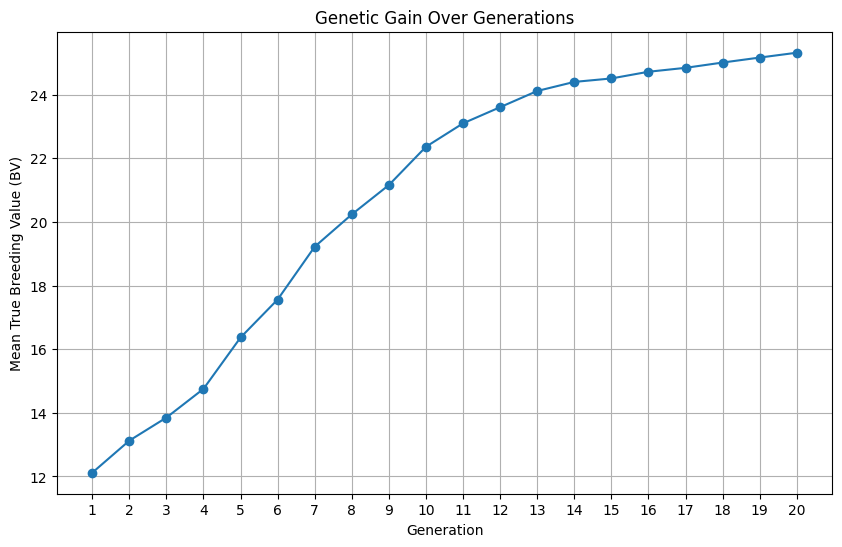

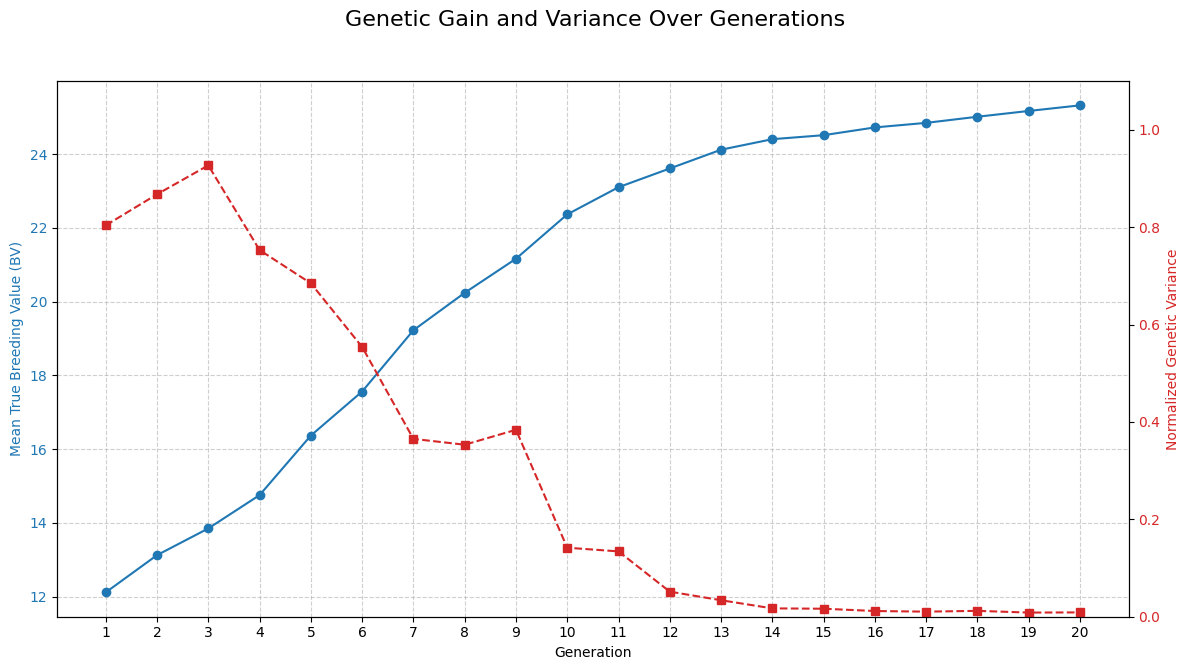

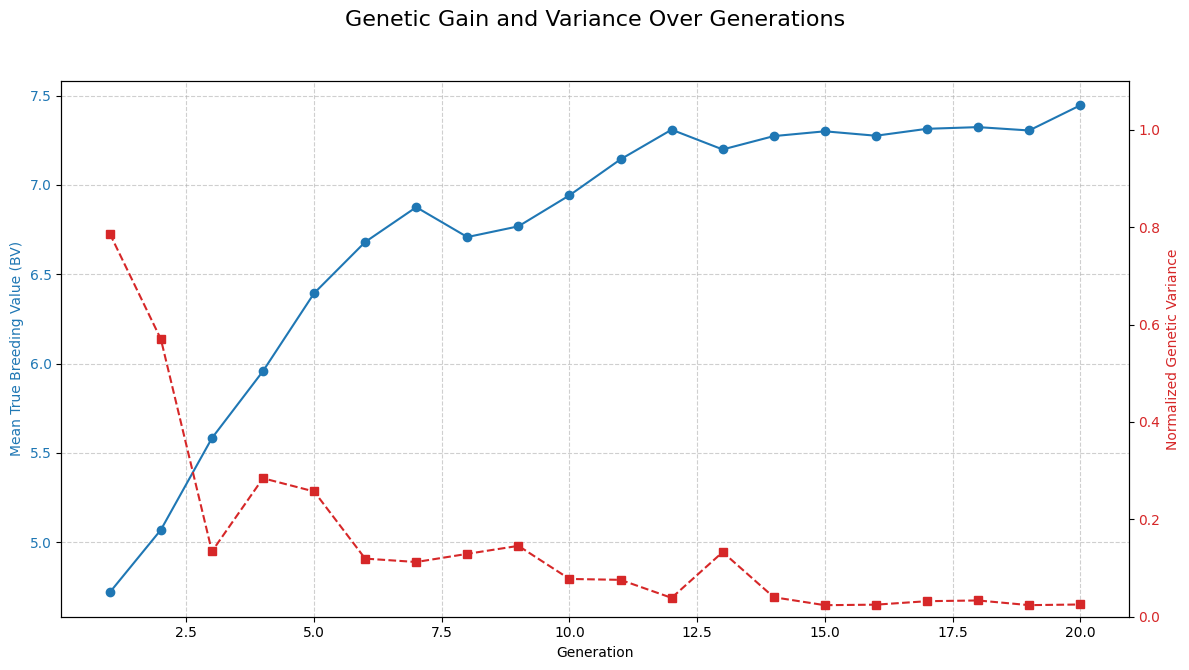

Final genetic gain: 7.45
Genetic variance retained: 2.51%


In [26]:
import jax
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt

from chewc.population import quick_haplo, combine_populations, subset_population
from chewc.sp import SimParam
from chewc.trait import add_trait_a
from chewc.phenotype import set_pheno, set_bv
from chewc.cross import make_cross
from chewc.predict import gblup_predict

# =============================================================================
# SIMULATION PARAMETERS
# =============================================================================
config = {
    "simulation": {"seed": 42, "n_generations": 20},
    "founder": {"n_ind": 100, "n_chr": 5, "n_loci_per_chr": 200},
    "trait": {"n_qtl_per_chr": 50, "mean": jnp.array([0.0]), 
              "var": jnp.array([1.0]), "h2_initial": 0.5},
    "breeding_program": {
        "n_elite_founders": 10,
        "training_population_size": 200,
        "n_parents_per_generation": 10,
        "n_offspring_per_cross": 5,
        "n_elite_selections_per_generation": 10,
        "h2_elite_phenotyping": 0.5
    }
}

# =============================================================================
# FOUNDER POPULATION SETUP
# =============================================================================
key = jax.random.PRNGKey(config["simulation"]["seed"])

# Create founder population with random haplotypes
key, pop_key = jax.random.split(key)
founder_pop, genetic_map = quick_haplo(
    key=pop_key,
    n_ind=config["founder"]["n_ind"],
    n_chr=config["founder"]["n_chr"],
    n_loci_per_chr=config["founder"]["n_loci_per_chr"]
)

# Initialize simulation parameters
sp = SimParam.from_founder_pop(founder_pop, genetic_map)

# Define quantitative trait architecture
key, trait_key = jax.random.split(key)
sp = add_trait_a(
    key=trait_key,
    founder_pop=founder_pop,
    sim_param=sp,
    n_qtl_per_chr=config["trait"]["n_qtl_per_chr"],
    mean=config["trait"]["mean"],
    var=config["trait"]["var"]
)

# Phenotype founders
key, pheno_key = jax.random.split(key)
founder_pop = set_pheno(
    key=pheno_key,
    pop=founder_pop,
    traits=sp.traits,
    ploidy=sp.ploidy,
    h2=jnp.array([config["trait"]["h2_initial"]])
)

# =============================================================================
# INITIAL TRAINING POPULATION
# =============================================================================
# Select elite founders based on phenotype
pheno_values = founder_pop.pheno[:, 0]
elite_indices = jnp.argsort(pheno_values)[-config["breeding_program"]["n_elite_founders"]:]

# Create factorial crosses between elite founders
sires = elite_indices[:len(elite_indices)//2]
dams = elite_indices[len(elite_indices)//2:]
cross_plan = jnp.array([[s, d] for s in sires for d in dams])

# Expand crosses to reach target training population size
target_size = config["breeding_program"]["training_population_size"]
n_offspring_needed = max(1, target_size // cross_plan.shape[0])
expanded_cross_plan = jnp.repeat(cross_plan, repeats=n_offspring_needed, axis=0)

# Generate training population
key, cross_key = jax.random.split(key)
training_pop = make_cross(
    key=cross_key,
    pop=founder_pop,
    cross_plan=expanded_cross_plan,
    sp=sp,
    next_id_start=founder_pop.nInd
)

# Phenotype training population and calculate breeding values
key, pheno_key = jax.random.split(key)
training_pop = set_pheno(
    key=pheno_key,
    pop=training_pop,
    traits=sp.traits,
    ploidy=sp.ploidy,
    h2=jnp.array([config["trait"]["h2_initial"]])
)
training_pop = set_bv(pop=training_pop, traits=sp.traits, ploidy=sp.ploidy)

# Store initial genetic variance for normalization
initial_genetic_variance = jnp.var(training_pop.bv).item()

# =============================================================================
# RECURRENT SELECTION LOOP
# =============================================================================
history = []
current_training_pop = training_pop

for gen in range(config["simulation"]["n_generations"]):
    # Train GBLUP model on current training data
    gblup_results = gblup_predict(pop=current_training_pop, h2=config["trait"]["h2_initial"])
    current_training_pop = current_training_pop.replace(ebv=gblup_results.ebv)
    
    # Select parents based on GEBVs
    n_parents = config["breeding_program"]["n_parents_per_generation"]
    parent_indices = jnp.argsort(current_training_pop.ebv[:, 0])[-n_parents:]
    
    # Create random mating pairs
    key, pair_key, cross_key = jax.random.split(key, 3)
    shuffled_parents = jax.random.permutation(pair_key, parent_indices)
    pairs = shuffled_parents.reshape(n_parents // 2, 2)
    
    # Generate selection candidates
    candidate_cross_plan = jnp.repeat(
        pairs, 
        repeats=config["breeding_program"]["n_offspring_per_cross"], 
        axis=0
    )
    
    candidates = make_cross(
        key=cross_key,
        pop=current_training_pop,
        cross_plan=candidate_cross_plan,
        sp=sp,
        next_id_start=jnp.max(current_training_pop.id) + 1
    )
    
    # Calculate true breeding values for evaluation
    candidates = set_bv(pop=candidates, traits=sp.traits, ploidy=sp.ploidy)
    
    # Predict GEBVs for unphenotyped candidates
    candidates_for_pred = candidates.replace(pheno=jnp.full((candidates.nInd, sp.n_traits), jnp.nan))
    combined_pop = combine_populations(current_training_pop, candidates_for_pred)
    combined_preds = gblup_predict(pop=combined_pop, h2=config["trait"]["h2_initial"])
    
    candidate_gebvs = combined_preds.ebv[current_training_pop.nInd:]
    candidates = candidates.replace(ebv=candidate_gebvs)
    
    # Select elite candidates for phenotyping
    n_elites = config["breeding_program"]["n_elite_selections_per_generation"]
    elite_indices = jnp.argsort(candidates.ebv[:, 0])[-n_elites:]
    elite_pop = subset_population(candidates, elite_indices)
    
    # Phenotype selected elites
    key, elite_pheno_key = jax.random.split(key)
    elite_pop = set_pheno(
        key=elite_pheno_key,
        pop=elite_pop,
        traits=sp.traits,
        ploidy=sp.ploidy,
        h2=jnp.array([config["breeding_program"]["h2_elite_phenotyping"]])
    )
    
    # Update training population with moving window approach
    training_pop_size = current_training_pop.nInd
    updated_pop = combine_populations(current_training_pop, elite_pop)
    current_training_pop = subset_population(updated_pop, jnp.arange(-training_pop_size, 0))
    
    # Record generation results
    current_genetic_variance = jnp.var(candidates.bv).item()
    results = {
        "generation": gen + 1,
        "mean_true_bv": jnp.mean(candidates.bv).item(),
        "var_true_bv": current_genetic_variance,
        "var_true_bv_normalized": current_genetic_variance / initial_genetic_variance,
        "mean_predicted_gebv": jnp.nanmean(candidates.ebv).item(),
        "prediction_accuracy": jnp.corrcoef(candidates.bv[:, 0], candidates.ebv[:, 0])[0, 1].item()
    }
    history.append(results)

# =============================================================================
# RESULTS VISUALIZATION
# =============================================================================
results_df = pd.DataFrame(history)

# Dual-axis plot: genetic gain and variance loss
fig, ax1 = plt.subplots(figsize=(12, 7))

# Genetic gain
color = 'tab:blue'
ax1.set_xlabel('Generation')
ax1.set_ylabel('Mean True Breeding Value (BV)', color=color)
ax1.plot(results_df['generation'], results_df['mean_true_bv'], 
         marker='o', linestyle='-', color=color, label='Genetic Gain')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, linestyle='--', alpha=0.6)

# Genetic variance
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Normalized Genetic Variance', color=color)
ax2.plot(results_df['generation'], results_df['var_true_bv_normalized'], 
         marker='s', linestyle='--', color=color, label='Genetic Variance')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, 1.1)

fig.suptitle('Genetic Gain and Variance Over Generations', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print(f"Final genetic gain: {results_df['mean_true_bv'].iloc[-1]:.2f}")
print(f"Genetic variance retained: {results_df['var_true_bv_normalized'].iloc[-1]:.2%}")

Running High Selection Intensity simulation...
Running Low Selection Intensity simulation...

COMPARATIVE RESULTS

High Selection Intensity:
  Final genetic gain: 7.693
  Genetic variance retained: 1.87%
  Average selection intensity: 10.00%

Low Selection Intensity:
  Final genetic gain: 7.929
  Genetic variance retained: 17.99%
  Average selection intensity: 20.00%


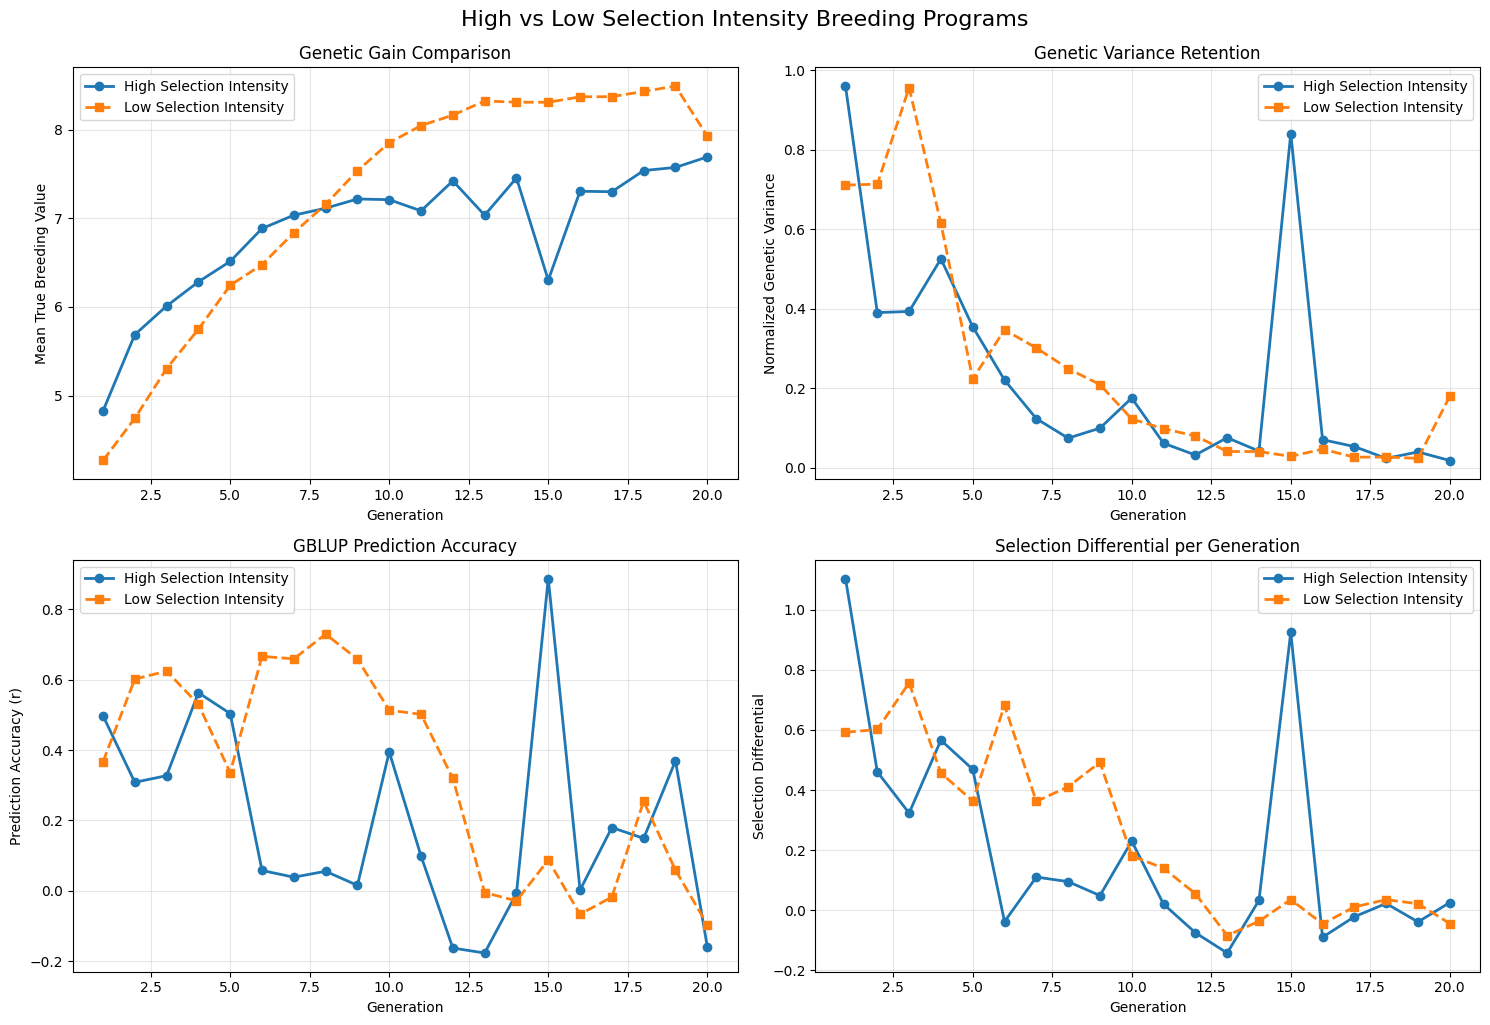


TRADE-OFF ANALYSIS:
High intensity gained -0.236 more genetic merit
But retained -16.1% less genetic variance
Gain per unit variance lost: -1.46


In [27]:
import jax
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt

from chewc.population import quick_haplo, combine_populations, subset_population
from chewc.sp import SimParam
from chewc.trait import add_trait_a
from chewc.phenotype import set_pheno, set_bv
from chewc.cross import make_cross
from chewc.predict import gblup_predict

# =============================================================================
# SIMULATION PARAMETERS
# =============================================================================
# High selection intensity scenario
config_high_intensity = {
    "name": "High Selection Intensity",
    "simulation": {"seed": 42, "n_generations": 20},
    "founder": {"n_ind": 100, "n_chr": 5, "n_loci_per_chr": 200},
    "trait": {"n_qtl_per_chr": 50, "mean": jnp.array([0.0]), 
              "var": jnp.array([1.0]), "h2_initial": 0.5},
    "breeding_program": {
        "n_elite_founders": 10,
        "training_population_size": 200,
        "n_parents_per_generation": 10,  # Few parents = high intensity
        "n_offspring_per_cross": 10,     # More offspring per cross
        "n_elite_selections_per_generation": 5,  # Very selective
        "h2_elite_phenotyping": 0.5
    }
}

# Low selection intensity scenario
config_low_intensity = {
    "name": "Low Selection Intensity", 
    "simulation": {"seed": 42, "n_generations": 20},
    "founder": {"n_ind": 100, "n_chr": 5, "n_loci_per_chr": 200},
    "trait": {"n_qtl_per_chr": 50, "mean": jnp.array([0.0]), 
              "var": jnp.array([1.0]), "h2_initial": 0.5},
    "breeding_program": {
        "n_elite_founders": 10,
        "training_population_size": 200,
        "n_parents_per_generation": 30,  # More parents = low intensity
        "n_offspring_per_cross": 5,      # Fewer offspring per cross
        "n_elite_selections_per_generation": 15,  # Less selective
        "h2_elite_phenotyping": 0.5
    }
}

def run_simulation(config):
    """Run a complete breeding simulation with given configuration"""
    
    # =============================================================================
    # FOUNDER POPULATION SETUP
    # =============================================================================
    key = jax.random.PRNGKey(config["simulation"]["seed"])
    
    # Create founder population with random haplotypes
    key, pop_key = jax.random.split(key)
    founder_pop, genetic_map = quick_haplo(
        key=pop_key,
        n_ind=config["founder"]["n_ind"],
        n_chr=config["founder"]["n_chr"],
        n_loci_per_chr=config["founder"]["n_loci_per_chr"]
    )
    
    # Initialize simulation parameters
    sp = SimParam.from_founder_pop(founder_pop, genetic_map)
    
    # Define quantitative trait architecture
    key, trait_key = jax.random.split(key)
    sp = add_trait_a(
        key=trait_key,
        founder_pop=founder_pop,
        sim_param=sp,
        n_qtl_per_chr=config["trait"]["n_qtl_per_chr"],
        mean=config["trait"]["mean"],
        var=config["trait"]["var"]
    )
    
    # Phenotype founders
    key, pheno_key = jax.random.split(key)
    founder_pop = set_pheno(
        key=pheno_key,
        pop=founder_pop,
        traits=sp.traits,
        ploidy=sp.ploidy,
        h2=jnp.array([config["trait"]["h2_initial"]])
    )
    
    # =============================================================================
    # INITIAL TRAINING POPULATION
    # =============================================================================
    # Select elite founders based on phenotype
    pheno_values = founder_pop.pheno[:, 0]
    elite_indices = jnp.argsort(pheno_values)[-config["breeding_program"]["n_elite_founders"]:]
    
    # Create factorial crosses between elite founders
    sires = elite_indices[:len(elite_indices)//2]
    dams = elite_indices[len(elite_indices)//2:]
    cross_plan = jnp.array([[s, d] for s in sires for d in dams])
    
    # Expand crosses to reach target training population size
    target_size = config["breeding_program"]["training_population_size"]
    n_offspring_needed = max(1, target_size // cross_plan.shape[0])
    expanded_cross_plan = jnp.repeat(cross_plan, repeats=n_offspring_needed, axis=0)
    
    # Generate training population
    key, cross_key = jax.random.split(key)
    training_pop = make_cross(
        key=cross_key,
        pop=founder_pop,
        cross_plan=expanded_cross_plan,
        sp=sp,
        next_id_start=founder_pop.nInd
    )
    
    # Phenotype training population and calculate breeding values
    key, pheno_key = jax.random.split(key)
    training_pop = set_pheno(
        key=pheno_key,
        pop=training_pop,
        traits=sp.traits,
        ploidy=sp.ploidy,
        h2=jnp.array([config["trait"]["h2_initial"]])
    )
    training_pop = set_bv(pop=training_pop, traits=sp.traits, ploidy=sp.ploidy)
    
    # Store initial genetic variance for normalization
    initial_genetic_variance = jnp.var(training_pop.bv).item()
    
    # =============================================================================
    # RECURRENT SELECTION LOOP
    # =============================================================================
    history = []
    current_training_pop = training_pop
    
    for gen in range(config["simulation"]["n_generations"]):
        # Train GBLUP model on current training data
        gblup_results = gblup_predict(pop=current_training_pop, h2=config["trait"]["h2_initial"])
        current_training_pop = current_training_pop.replace(ebv=gblup_results.ebv)
        
        # Select parents based on GEBVs
        n_parents = config["breeding_program"]["n_parents_per_generation"]
        parent_indices = jnp.argsort(current_training_pop.ebv[:, 0])[-n_parents:]
        
        # Create random mating pairs
        key, pair_key, cross_key = jax.random.split(key, 3)
        shuffled_parents = jax.random.permutation(pair_key, parent_indices)
        pairs = shuffled_parents.reshape(n_parents // 2, 2)
        
        # Generate selection candidates
        candidate_cross_plan = jnp.repeat(
            pairs, 
            repeats=config["breeding_program"]["n_offspring_per_cross"], 
            axis=0
        )
        
        candidates = make_cross(
            key=cross_key,
            pop=current_training_pop,
            cross_plan=candidate_cross_plan,
            sp=sp,
            next_id_start=jnp.max(current_training_pop.id) + 1
        )
        
        # Calculate true breeding values for evaluation
        candidates = set_bv(pop=candidates, traits=sp.traits, ploidy=sp.ploidy)
        
        # Predict GEBVs for unphenotyped candidates
        candidates_for_pred = candidates.replace(pheno=jnp.full((candidates.nInd, sp.n_traits), jnp.nan))
        combined_pop = combine_populations(current_training_pop, candidates_for_pred)
        combined_preds = gblup_predict(pop=combined_pop, h2=config["trait"]["h2_initial"])
        
        candidate_gebvs = combined_preds.ebv[current_training_pop.nInd:]
        candidates = candidates.replace(ebv=candidate_gebvs)
        
        # Select elite candidates for phenotyping
        n_elites = config["breeding_program"]["n_elite_selections_per_generation"]
        elite_indices = jnp.argsort(candidates.ebv[:, 0])[-n_elites:]
        elite_pop = subset_population(candidates, elite_indices)
        
        # Phenotype selected elites
        key, elite_pheno_key = jax.random.split(key)
        elite_pop = set_pheno(
            key=elite_pheno_key,
            pop=elite_pop,
            traits=sp.traits,
            ploidy=sp.ploidy,
            h2=jnp.array([config["breeding_program"]["h2_elite_phenotyping"]])
        )
        
        # Update training population with moving window approach
        training_pop_size = current_training_pop.nInd
        updated_pop = combine_populations(current_training_pop, elite_pop)
        current_training_pop = subset_population(updated_pop, jnp.arange(-training_pop_size, 0))
        
        # Record generation results
        current_genetic_variance = jnp.var(candidates.bv).item()
        
        # Calculate selection intensity metrics
        selection_differential = jnp.mean(elite_pop.bv) - jnp.mean(candidates.bv)
        selection_intensity = n_elites / candidates.nInd
        
        results = {
            "generation": gen + 1,
            "mean_true_bv": jnp.mean(candidates.bv).item(),
            "var_true_bv": current_genetic_variance,
            "var_true_bv_normalized": current_genetic_variance / initial_genetic_variance,
            "mean_predicted_gebv": jnp.nanmean(candidates.ebv).item(),
            "prediction_accuracy": jnp.corrcoef(candidates.bv[:, 0], candidates.ebv[:, 0])[0, 1].item(),
            "selection_differential": selection_differential.item(),
            "selection_intensity": selection_intensity
        }
        history.append(results)
    
    return pd.DataFrame(history), config["name"]

# =============================================================================
# RUN BOTH SIMULATIONS
# =============================================================================
print("Running High Selection Intensity simulation...")
results_high, name_high = run_simulation(config_high_intensity)

print("Running Low Selection Intensity simulation...")
results_low, name_low = run_simulation(config_low_intensity)

# =============================================================================
# COMPARATIVE ANALYSIS
# =============================================================================
# Summary statistics
print("\n" + "="*60)
print("COMPARATIVE RESULTS")
print("="*60)

print(f"\n{name_high}:")
print(f"  Final genetic gain: {results_high['mean_true_bv'].iloc[-1]:.3f}")
print(f"  Genetic variance retained: {results_high['var_true_bv_normalized'].iloc[-1]:.2%}")
print(f"  Average selection intensity: {results_high['selection_intensity'].mean():.2%}")

print(f"\n{name_low}:")
print(f"  Final genetic gain: {results_low['mean_true_bv'].iloc[-1]:.3f}")
print(f"  Genetic variance retained: {results_low['var_true_bv_normalized'].iloc[-1]:.2%}")
print(f"  Average selection intensity: {results_low['selection_intensity'].mean():.2%}")

# =============================================================================
# COMPARATIVE VISUALIZATION
# =============================================================================
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Genetic Gain Comparison
ax1.plot(results_high['generation'], results_high['mean_true_bv'], 
         marker='o', linestyle='-', label=name_high, linewidth=2)
ax1.plot(results_low['generation'], results_low['mean_true_bv'], 
         marker='s', linestyle='--', label=name_low, linewidth=2)
ax1.set_xlabel('Generation')
ax1.set_ylabel('Mean True Breeding Value')
ax1.set_title('Genetic Gain Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Genetic Variance Loss
ax2.plot(results_high['generation'], results_high['var_true_bv_normalized'], 
         marker='o', linestyle='-', label=name_high, linewidth=2)
ax2.plot(results_low['generation'], results_low['var_true_bv_normalized'], 
         marker='s', linestyle='--', label=name_low, linewidth=2)
ax2.set_xlabel('Generation')
ax2.set_ylabel('Normalized Genetic Variance')
ax2.set_title('Genetic Variance Retention')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Prediction Accuracy
ax3.plot(results_high['generation'], results_high['prediction_accuracy'], 
         marker='o', linestyle='-', label=name_high, linewidth=2)
ax3.plot(results_low['generation'], results_low['prediction_accuracy'], 
         marker='s', linestyle='--', label=name_low, linewidth=2)
ax3.set_xlabel('Generation')
ax3.set_ylabel('Prediction Accuracy (r)')
ax3.set_title('GBLUP Prediction Accuracy')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Selection Differential
ax4.plot(results_high['generation'], results_high['selection_differential'], 
         marker='o', linestyle='-', label=name_high, linewidth=2)
ax4.plot(results_low['generation'], results_low['selection_differential'], 
         marker='s', linestyle='--', label=name_low, linewidth=2)
ax4.set_xlabel('Generation')
ax4.set_ylabel('Selection Differential')
ax4.set_title('Selection Differential per Generation')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('High vs Low Selection Intensity Breeding Programs', 
             fontsize=16, y=1.02)
plt.show()

# Print trade-off analysis
gain_diff = results_high['mean_true_bv'].iloc[-1] - results_low['mean_true_bv'].iloc[-1]
variance_diff = results_high['var_true_bv_normalized'].iloc[-1] - results_low['var_true_bv_normalized'].iloc[-1]

print(f"\nTRADE-OFF ANALYSIS:")
print(f"High intensity gained {gain_diff:.3f} more genetic merit")
print(f"But retained {variance_diff:.1%} less genetic variance")
print(f"Gain per unit variance lost: {gain_diff / abs(variance_diff):.2f}" if variance_diff != 0 else "No variance difference")

Starting replicated breeding simulations...
Running High Selection Intensity with 10 replicates...
Running Low Selection Intensity with 10 replicates...

REPLICATED SIMULATION RESULTS

High Selection Intensity (n=10):
  Final genetic gain: 4.916 ± 0.351
  Variance retained: 0.045 ± 0.014

Low Selection Intensity (n=10):
  Final genetic gain: 5.504 ± 0.326
  Variance retained: 0.096 ± 0.046

STATISTICAL TESTS:
  Genetic gain difference: t=-1.228, p=0.2354
  Variance retention difference: t=-1.055, p=0.3056


/tmp/ipykernel_55255/1280892943.py:328: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax4.boxplot(final_data, labels=[config_high_intensity['name'], config_low_intensity['name']])


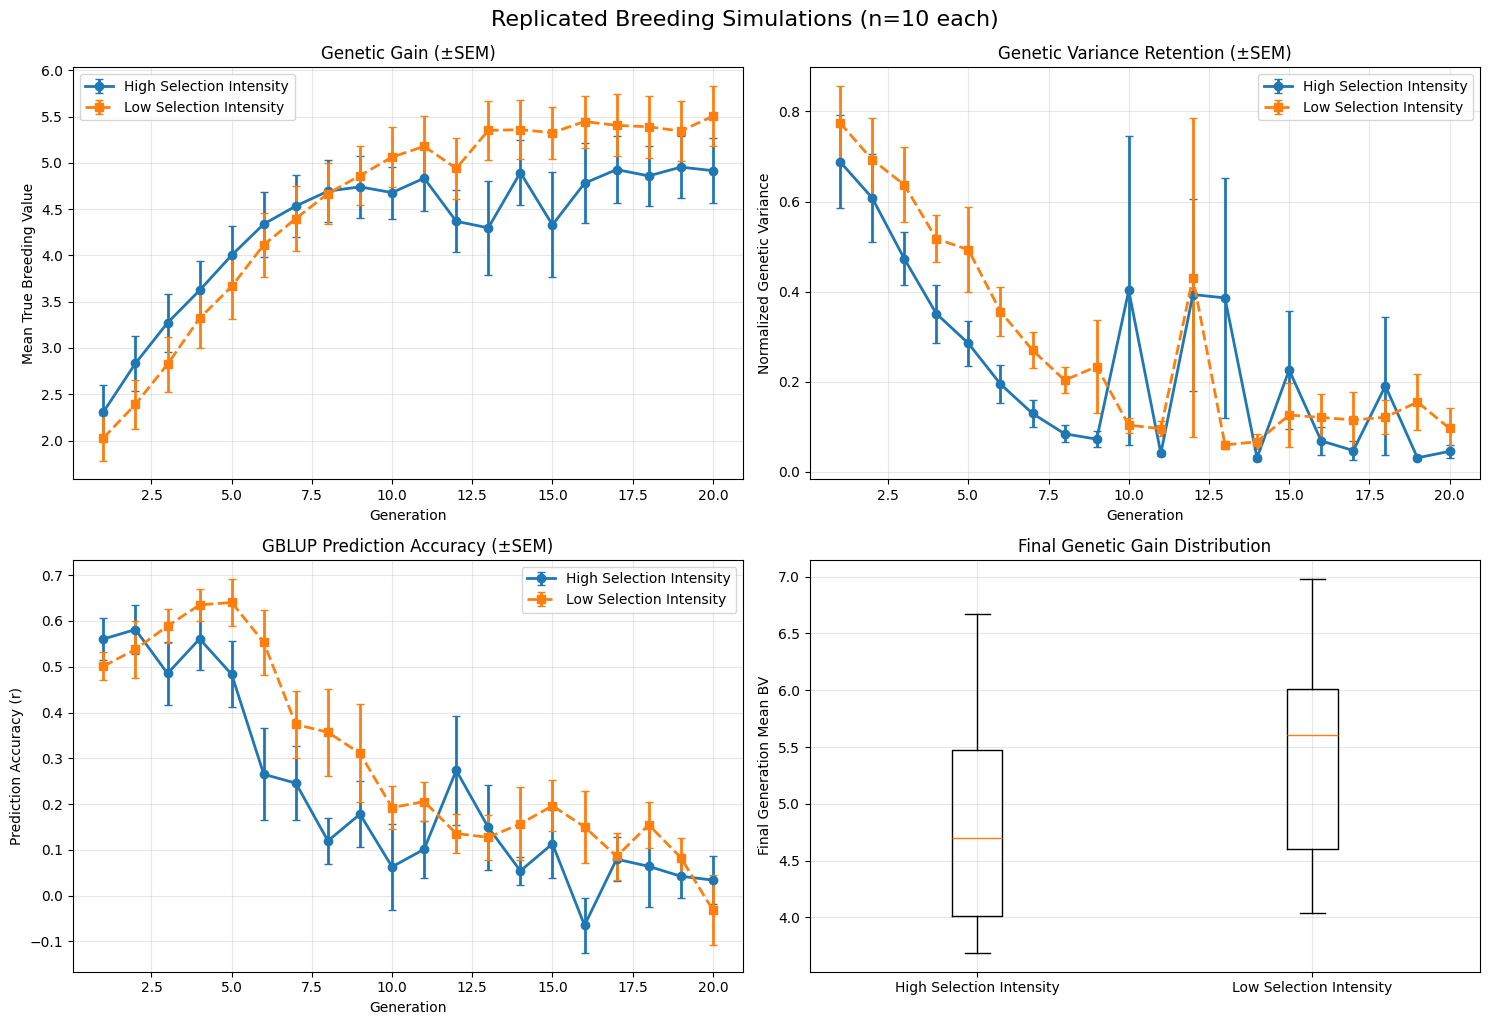


EFFECT SIZE (Cohen's d): -0.579
  Interpretation: Medium effect


In [29]:
import jax
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

from chewc.population import quick_haplo, combine_populations, subset_population
from chewc.sp import SimParam
from chewc.trait import add_trait_a
from chewc.phenotype import set_pheno, set_bv
from chewc.cross import make_cross
from chewc.predict import gblup_predict

# =============================================================================
# SIMULATION PARAMETERS
# =============================================================================
# High selection intensity scenario
config_high_intensity = {
    "name": "High Selection Intensity",
    "simulation": {"n_generations": 20, "n_replicates": 10},
    "founder": {"n_ind": 100, "n_chr": 5, "n_loci_per_chr": 200},
    "trait": {"n_qtl_per_chr": 50, "mean": jnp.array([0.0]), 
              "var": jnp.array([1.0]), "h2_initial": 0.3},
    "breeding_program": {
        "n_elite_founders": 10,
        "training_population_size": 200,
        "n_parents_per_generation": 10,
        "n_offspring_per_cross": 10,
        "n_elite_selections_per_generation": 5,
        "h2_elite_phenotyping": 0.5
    }
}

# Low selection intensity scenario
config_low_intensity = {
    "name": "Low Selection Intensity", 
    "simulation": {"n_generations": 20, "n_replicates": 10},
    "founder": {"n_ind": 100, "n_chr": 5, "n_loci_per_chr": 200},
    "trait": {"n_qtl_per_chr": 50, "mean": jnp.array([0.0]), 
              "var": jnp.array([1.0]), "h2_initial": 0.3},
    "breeding_program": {
        "n_elite_founders": 10,
        "training_population_size": 200,
        "n_parents_per_generation": 30,
        "n_offspring_per_cross": 5,
        "n_elite_selections_per_generation": 15,
        "h2_elite_phenotyping": 0.5
    }
}

def run_single_replicate(config, replicate_seed):
    """Run a single replicate of the breeding simulation"""
    
    key = jax.random.PRNGKey(replicate_seed)
    
    # Create founder population
    key, pop_key = jax.random.split(key)
    founder_pop, genetic_map = quick_haplo(
        key=pop_key,
        n_ind=config["founder"]["n_ind"],
        n_chr=config["founder"]["n_chr"],
        n_loci_per_chr=config["founder"]["n_loci_per_chr"]
    )
    
    # Initialize simulation parameters
    sp = SimParam.from_founder_pop(founder_pop, genetic_map)
    
    # Define quantitative trait architecture
    key, trait_key = jax.random.split(key)
    sp = add_trait_a(
        key=trait_key,
        founder_pop=founder_pop,
        sim_param=sp,
        n_qtl_per_chr=config["trait"]["n_qtl_per_chr"],
        mean=config["trait"]["mean"],
        var=config["trait"]["var"]
    )
    
    # Phenotype founders
    key, pheno_key = jax.random.split(key)
    founder_pop = set_pheno(
        key=pheno_key,
        pop=founder_pop,
        traits=sp.traits,
        ploidy=sp.ploidy,
        h2=jnp.array([config["trait"]["h2_initial"]])
    )
    
    # Create initial training population
    pheno_values = founder_pop.pheno[:, 0]
    elite_indices = jnp.argsort(pheno_values)[-config["breeding_program"]["n_elite_founders"]:]
    
    sires = elite_indices[:len(elite_indices)//2]
    dams = elite_indices[len(elite_indices)//2:]
    cross_plan = jnp.array([[s, d] for s in sires for d in dams])
    
    target_size = config["breeding_program"]["training_population_size"]
    n_offspring_needed = max(1, target_size // cross_plan.shape[0])
    expanded_cross_plan = jnp.repeat(cross_plan, repeats=n_offspring_needed, axis=0)
    
    key, cross_key = jax.random.split(key)
    training_pop = make_cross(
        key=cross_key,
        pop=founder_pop,
        cross_plan=expanded_cross_plan,
        sp=sp,
        next_id_start=founder_pop.nInd
    )
    
    key, pheno_key = jax.random.split(key)
    training_pop = set_pheno(
        key=pheno_key,
        pop=training_pop,
        traits=sp.traits,
        ploidy=sp.ploidy,
        h2=jnp.array([config["trait"]["h2_initial"]])
    )
    training_pop = set_bv(pop=training_pop, traits=sp.traits, ploidy=sp.ploidy)
    
    initial_genetic_variance = jnp.var(training_pop.bv).item()
    
    # Recurrent selection loop
    history = []
    current_training_pop = training_pop
    
    for gen in range(config["simulation"]["n_generations"]):
        # Train GBLUP and select parents
        gblup_results = gblup_predict(pop=current_training_pop, h2=config["trait"]["h2_initial"])
        current_training_pop = current_training_pop.replace(ebv=gblup_results.ebv)
        
        n_parents = config["breeding_program"]["n_parents_per_generation"]
        parent_indices = jnp.argsort(current_training_pop.ebv[:, 0])[-n_parents:]
        
        # Create mating pairs and generate candidates
        key, pair_key, cross_key = jax.random.split(key, 3)
        shuffled_parents = jax.random.permutation(pair_key, parent_indices)
        pairs = shuffled_parents.reshape(n_parents // 2, 2)
        
        candidate_cross_plan = jnp.repeat(
            pairs, 
            repeats=config["breeding_program"]["n_offspring_per_cross"], 
            axis=0
        )
        
        candidates = make_cross(
            key=cross_key,
            pop=current_training_pop,
            cross_plan=candidate_cross_plan,
            sp=sp,
            next_id_start=jnp.max(current_training_pop.id) + 1
        )
        
        candidates = set_bv(pop=candidates, traits=sp.traits, ploidy=sp.ploidy)
        
        # Predict GEBVs for candidates
        candidates_for_pred = candidates.replace(pheno=jnp.full((candidates.nInd, sp.n_traits), jnp.nan))
        combined_pop = combine_populations(current_training_pop, candidates_for_pred)
        combined_preds = gblup_predict(pop=combined_pop, h2=config["trait"]["h2_initial"])
        
        candidate_gebvs = combined_preds.ebv[current_training_pop.nInd:]
        candidates = candidates.replace(ebv=candidate_gebvs)
        
        # Select and phenotype elites
        n_elites = config["breeding_program"]["n_elite_selections_per_generation"]
        elite_indices = jnp.argsort(candidates.ebv[:, 0])[-n_elites:]
        elite_pop = subset_population(candidates, elite_indices)
        
        key, elite_pheno_key = jax.random.split(key)
        elite_pop = set_pheno(
            key=elite_pheno_key,
            pop=elite_pop,
            traits=sp.traits,
            ploidy=sp.ploidy,
            h2=jnp.array([config["breeding_program"]["h2_elite_phenotyping"]])
        )
        
        # Update training population
        training_pop_size = current_training_pop.nInd
        updated_pop = combine_populations(current_training_pop, elite_pop)
        current_training_pop = subset_population(updated_pop, jnp.arange(-training_pop_size, 0))
        
        # Record results
        current_genetic_variance = jnp.var(candidates.bv).item()
        selection_differential = jnp.mean(elite_pop.bv) - jnp.mean(candidates.bv)
        
        results = {
            "generation": gen + 1,
            "mean_true_bv": jnp.mean(candidates.bv).item(),
            "var_true_bv_normalized": current_genetic_variance / initial_genetic_variance,
            "prediction_accuracy": jnp.corrcoef(candidates.bv[:, 0], candidates.ebv[:, 0])[0, 1].item(),
            "selection_differential": selection_differential.item(),
        }
        history.append(results)
    
    return pd.DataFrame(history)

def run_replicated_simulation(config):
    """Run multiple replicates and calculate summary statistics"""
    
    print(f"Running {config['name']} with {config['simulation']['n_replicates']} replicates...")
    
    all_replicates = []
    base_seed = 12345  # Base seed for reproducibility
    
    for rep in range(config["simulation"]["n_replicates"]):
        replicate_seed = base_seed + rep
        replicate_results = run_single_replicate(config, replicate_seed)
        replicate_results['replicate'] = rep + 1
        all_replicates.append(replicate_results)
    
    # Combine all replicates
    combined_df = pd.concat(all_replicates, ignore_index=True)
    
    # Calculate summary statistics by generation
    summary_stats = combined_df.groupby('generation').agg({
        'mean_true_bv': ['mean', 'std', 'sem'],
        'var_true_bv_normalized': ['mean', 'std', 'sem'],
        'prediction_accuracy': ['mean', 'std', 'sem'],
        'selection_differential': ['mean', 'std', 'sem']
    }).round(4)
    
    # Flatten column names
    summary_stats.columns = ['_'.join(col).strip() for col in summary_stats.columns]
    summary_stats = summary_stats.reset_index()
    
    return summary_stats, combined_df

# =============================================================================
# RUN REPLICATED SIMULATIONS
# =============================================================================
print("Starting replicated breeding simulations...")

summary_high, raw_high = run_replicated_simulation(config_high_intensity)
summary_low, raw_low = run_replicated_simulation(config_low_intensity)

# =============================================================================
# STATISTICAL ANALYSIS
# =============================================================================
def perform_statistical_tests(summary_high, summary_low):
    """Perform t-tests between scenarios at final generation"""
    
    final_gen = summary_high['generation'].max()
    
    # Extract final generation data from raw replicates
    final_high = raw_high[raw_high['generation'] == final_gen]['mean_true_bv']
    final_low = raw_low[raw_low['generation'] == final_gen]['mean_true_bv']
    
    # Two-sample t-test for genetic gain
    gain_ttest = stats.ttest_ind(final_high, final_low)
    
    # Extract variance data
    var_high = raw_high[raw_high['generation'] == final_gen]['var_true_bv_normalized']
    var_low = raw_low[raw_low['generation'] == final_gen]['var_true_bv_normalized']
    
    # Two-sample t-test for variance retention
    var_ttest = stats.ttest_ind(var_high, var_low)
    
    return gain_ttest, var_ttest, final_high, final_low, var_high, var_low

gain_test, var_test, final_gain_high, final_gain_low, final_var_high, final_var_low = perform_statistical_tests(summary_high, summary_low)

# =============================================================================
# RESULTS SUMMARY
# =============================================================================
print("\n" + "="*80)
print("REPLICATED SIMULATION RESULTS")
print("="*80)

print(f"\n{config_high_intensity['name']} (n={config_high_intensity['simulation']['n_replicates']}):")
print(f"  Final genetic gain: {summary_high.iloc[-1]['mean_true_bv_mean']:.3f} ± {summary_high.iloc[-1]['mean_true_bv_sem']:.3f}")
print(f"  Variance retained: {summary_high.iloc[-1]['var_true_bv_normalized_mean']:.3f} ± {summary_high.iloc[-1]['var_true_bv_normalized_sem']:.3f}")

print(f"\n{config_low_intensity['name']} (n={config_low_intensity['simulation']['n_replicates']}):")
print(f"  Final genetic gain: {summary_low.iloc[-1]['mean_true_bv_mean']:.3f} ± {summary_low.iloc[-1]['mean_true_bv_sem']:.3f}")
print(f"  Variance retained: {summary_low.iloc[-1]['var_true_bv_normalized_mean']:.3f} ± {summary_low.iloc[-1]['var_true_bv_normalized_sem']:.3f}")

print(f"\nSTATISTICAL TESTS:")
print(f"  Genetic gain difference: t={gain_test.statistic:.3f}, p={gain_test.pvalue:.4f}")
print(f"  Variance retention difference: t={var_test.statistic:.3f}, p={var_test.pvalue:.4f}")

# =============================================================================
# VISUALIZATION WITH ERROR BARS
# =============================================================================
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Genetic Gain with Error Bars
ax1.errorbar(summary_high['generation'], summary_high['mean_true_bv_mean'], 
             yerr=summary_high['mean_true_bv_sem'], marker='o', linestyle='-', 
             label=config_high_intensity['name'], linewidth=2, capsize=3)
ax1.errorbar(summary_low['generation'], summary_low['mean_true_bv_mean'], 
             yerr=summary_low['mean_true_bv_sem'], marker='s', linestyle='--', 
             label=config_low_intensity['name'], linewidth=2, capsize=3)
ax1.set_xlabel('Generation')
ax1.set_ylabel('Mean True Breeding Value')
ax1.set_title('Genetic Gain (±SEM)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Genetic Variance with Error Bars
ax2.errorbar(summary_high['generation'], summary_high['var_true_bv_normalized_mean'], 
             yerr=summary_high['var_true_bv_normalized_sem'], marker='o', linestyle='-', 
             label=config_high_intensity['name'], linewidth=2, capsize=3)
ax2.errorbar(summary_low['generation'], summary_low['var_true_bv_normalized_mean'], 
             yerr=summary_low['var_true_bv_normalized_sem'], marker='s', linestyle='--', 
             label=config_low_intensity['name'], linewidth=2, capsize=3)
ax2.set_xlabel('Generation')
ax2.set_ylabel('Normalized Genetic Variance')
ax2.set_title('Genetic Variance Retention (±SEM)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Prediction Accuracy
ax3.errorbar(summary_high['generation'], summary_high['prediction_accuracy_mean'], 
             yerr=summary_high['prediction_accuracy_sem'], marker='o', linestyle='-', 
             label=config_high_intensity['name'], linewidth=2, capsize=3)
ax3.errorbar(summary_low['generation'], summary_low['prediction_accuracy_mean'], 
             yerr=summary_low['prediction_accuracy_sem'], marker='s', linestyle='--', 
             label=config_low_intensity['name'], linewidth=2, capsize=3)
ax3.set_xlabel('Generation')
ax3.set_ylabel('Prediction Accuracy (r)')
ax3.set_title('GBLUP Prediction Accuracy (±SEM)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Box plots of final generation results
final_data = [final_gain_high, final_gain_low]
ax4.boxplot(final_data, labels=[config_high_intensity['name'], config_low_intensity['name']])
ax4.set_ylabel('Final Generation Mean BV')
ax4.set_title('Final Genetic Gain Distribution')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle(f'Replicated Breeding Simulations (n={config_high_intensity["simulation"]["n_replicates"]} each)', 
             fontsize=16, y=1.02)
plt.show()

# Effect size calculation
effect_size = (np.mean(final_gain_high) - np.mean(final_gain_low)) / np.sqrt((np.var(final_gain_high) + np.var(final_gain_low)) / 2)
print(f"\nEFFECT SIZE (Cohen's d): {effect_size:.3f}")
if abs(effect_size) < 0.2:
    print("  Interpretation: Small effect")
elif abs(effect_size) < 0.8:
    print("  Interpretation: Medium effect")
else:
    print("  Interpretation: Large effect")

Starting replicated breeding simulations with improved key management...
Running High Selection Intensity with 10 replicates...
  Completed 5/10 replicates
  Completed 10/10 replicates
Running Low Selection Intensity with 10 replicates...
  Completed 5/10 replicates
  Completed 10/10 replicates

REPLICATED SIMULATION RESULTS (Improved Key Management)

High Selection Intensity (n=10):
  Final genetic gain: 5.956 ± 0.462
  Variance retained: 0.145 ± 0.113

Low Selection Intensity (n=10):
  Final genetic gain: 6.465 ± 0.373
  Variance retained: 0.090 ± 0.033

STATISTICAL TESTS:
  Genetic gain difference: t=-0.856, p=0.4032
  Variance retention difference: t=0.471, p=0.6436


/tmp/ipykernel_55255/1559323032.py:358: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax4.boxplot(final_data, labels=[config_high_intensity['name'], config_low_intensity['name']])


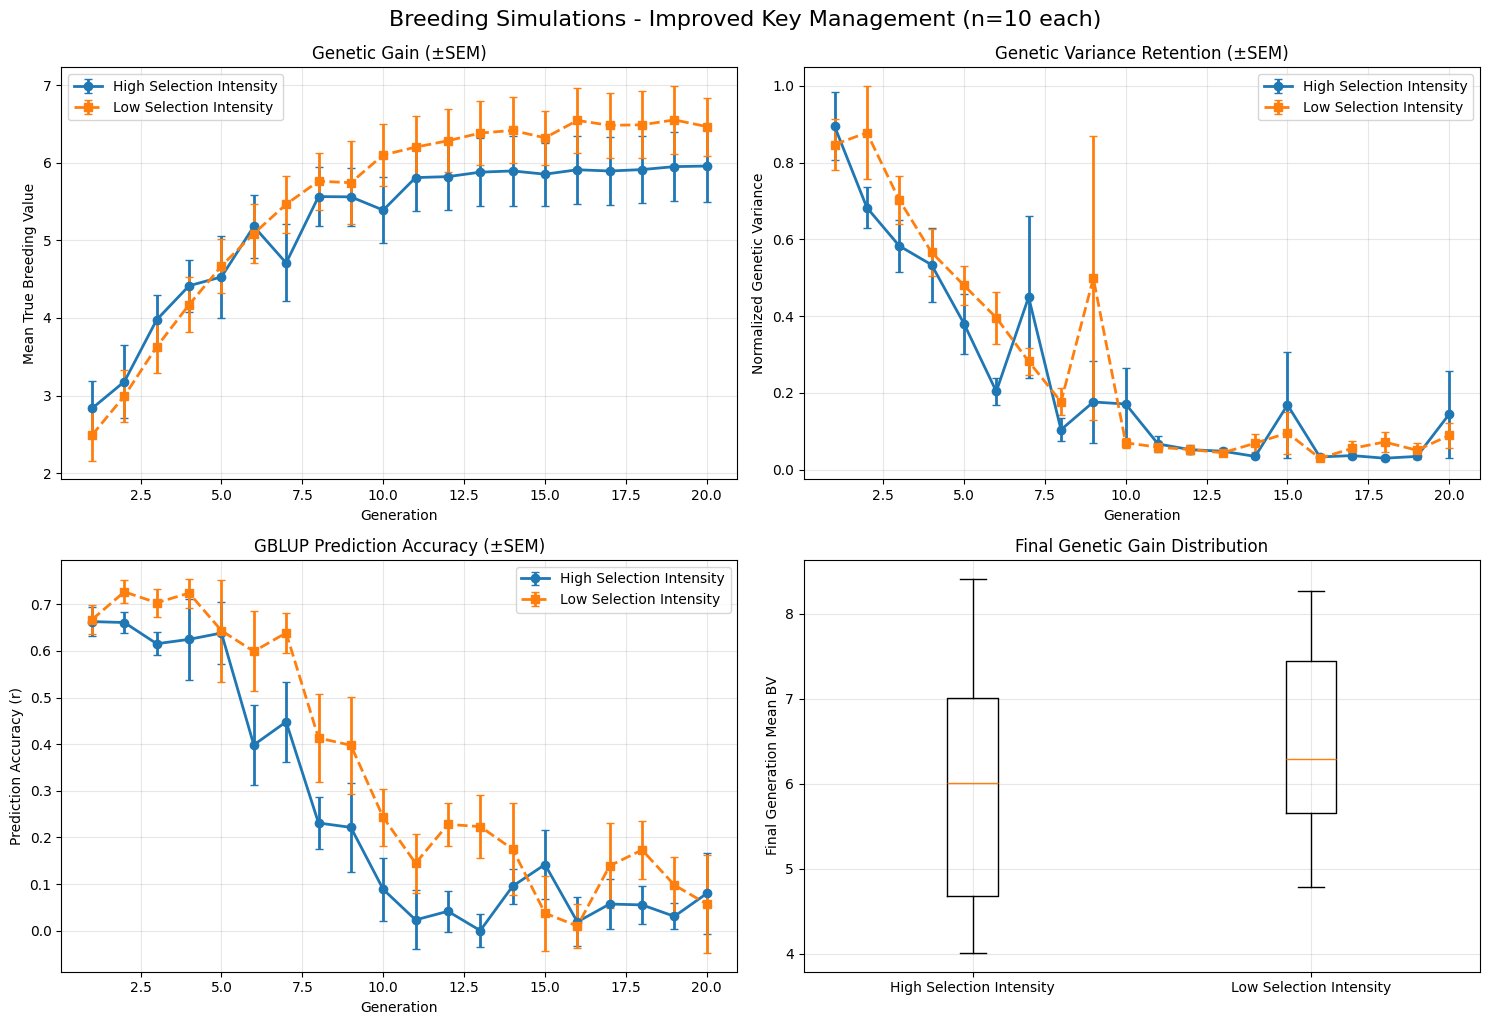


EFFECT SIZE (Cohen's d): -0.404
  Interpretation: Medium effect

KEY MANAGEMENT SUMMARY:
  Master key splits: 10 replicate keys
  Per replicate: 5 major operation keys + 20 generation keys
  Per generation: 3 sub-operation keys (mating, crossing, phenotyping)
  Total independence: Each random operation uses a unique key path


In [30]:
import jax
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

from chewc.population import quick_haplo, combine_populations, subset_population
from chewc.sp import SimParam
from chewc.trait import add_trait_a
from chewc.phenotype import set_pheno, set_bv
from chewc.cross import make_cross
from chewc.predict import gblup_predict

# =============================================================================
# SIMULATION PARAMETERS
# =============================================================================
# High selection intensity scenario
config_high_intensity = {
    "name": "High Selection Intensity",
    "simulation": {"n_generations": 20, "n_replicates": 10},
    "founder": {"n_ind": 100, "n_chr": 5, "n_loci_per_chr": 200},
    "trait": {"n_qtl_per_chr": 50, "mean": jnp.array([0.0]), 
              "var": jnp.array([1.0]), "h2_initial": 0.5},
    "breeding_program": {
        "n_elite_founders": 10,
        "training_population_size": 200,
        "n_parents_per_generation": 10,
        "n_offspring_per_cross": 10,
        "n_elite_selections_per_generation": 5,
        "h2_elite_phenotyping": 0.5
    }
}

# Low selection intensity scenario
config_low_intensity = {
    "name": "Low Selection Intensity", 
    "simulation": {"n_generations": 20, "n_replicates": 10},
    "founder": {"n_ind": 100, "n_chr": 5, "n_loci_per_chr": 200},
    "trait": {"n_qtl_per_chr": 50, "mean": jnp.array([0.0]), 
              "var": jnp.array([1.0]), "h2_initial": 0.5},
    "breeding_program": {
        "n_elite_founders": 10,
        "training_population_size": 200,
        "n_parents_per_generation": 30,
        "n_offspring_per_cross": 5,
        "n_elite_selections_per_generation": 15,
        "h2_elite_phenotyping": 0.5
    }
}

def run_single_replicate(config, master_key):
    """Run a single replicate with proper key management"""
    
    # Create a dedicated key tree for this entire replicate
    setup_key, trait_key, founder_pheno_key, training_key, selection_key = jax.random.split(master_key, 5)
    
    # =============================================================================
    # FOUNDER POPULATION SETUP
    # =============================================================================
    founder_pop, genetic_map = quick_haplo(
        key=setup_key,
        n_ind=config["founder"]["n_ind"],
        n_chr=config["founder"]["n_chr"],
        n_loci_per_chr=config["founder"]["n_loci_per_chr"]
    )
    
    sp = SimParam.from_founder_pop(founder_pop, genetic_map)
    
    sp = add_trait_a(
        key=trait_key,
        founder_pop=founder_pop,
        sim_param=sp,
        n_qtl_per_chr=config["trait"]["n_qtl_per_chr"],
        mean=config["trait"]["mean"],
        var=config["trait"]["var"]
    )
    
    founder_pop = set_pheno(
        key=founder_pheno_key,
        pop=founder_pop,
        traits=sp.traits,
        ploidy=sp.ploidy,
        h2=jnp.array([config["trait"]["h2_initial"]])
    )
    
    # =============================================================================
    # INITIAL TRAINING POPULATION
    # =============================================================================
    pheno_values = founder_pop.pheno[:, 0]
    elite_indices = jnp.argsort(pheno_values)[-config["breeding_program"]["n_elite_founders"]:]
    
    sires = elite_indices[:len(elite_indices)//2]
    dams = elite_indices[len(elite_indices)//2:]
    cross_plan = jnp.array([[s, d] for s in sires for d in dams])
    
    target_size = config["breeding_program"]["training_population_size"]
    n_offspring_needed = max(1, target_size // cross_plan.shape[0])
    expanded_cross_plan = jnp.repeat(cross_plan, repeats=n_offspring_needed, axis=0)
    
    # Split training_key for crossing and phenotyping
    training_cross_key, training_pheno_key = jax.random.split(training_key)
    
    training_pop = make_cross(
        key=training_cross_key,
        pop=founder_pop,
        cross_plan=expanded_cross_plan,
        sp=sp,
        next_id_start=founder_pop.nInd
    )
    
    training_pop = set_pheno(
        key=training_pheno_key,
        pop=training_pop,
        traits=sp.traits,
        ploidy=sp.ploidy,
        h2=jnp.array([config["trait"]["h2_initial"]])
    )
    training_pop = set_bv(pop=training_pop, traits=sp.traits, ploidy=sp.ploidy)
    
    initial_genetic_variance = jnp.var(training_pop.bv).item()
    
    # =============================================================================
    # RECURRENT SELECTION LOOP
    # =============================================================================
    history = []
    current_training_pop = training_pop
    
    # Generate independent keys for each generation
    n_generations = config["simulation"]["n_generations"]
    generation_keys = jax.random.split(selection_key, n_generations)
    
    for gen in range(n_generations):
        # Use a unique key for this generation
        gen_key = generation_keys[gen]
        
        # Split generation key into component operations
        mating_key, crossing_key, elite_pheno_key = jax.random.split(gen_key, 3)
        
        # Train GBLUP and select parents
        gblup_results = gblup_predict(pop=current_training_pop, h2=config["trait"]["h2_initial"])
        current_training_pop = current_training_pop.replace(ebv=gblup_results.ebv)
        
        n_parents = config["breeding_program"]["n_parents_per_generation"]
        parent_indices = jnp.argsort(current_training_pop.ebv[:, 0])[-n_parents:]
        
        # Create mating pairs with dedicated randomness
        shuffled_parents = jax.random.permutation(mating_key, parent_indices)
        pairs = shuffled_parents.reshape(n_parents // 2, 2)
        
        candidate_cross_plan = jnp.repeat(
            pairs, 
            repeats=config["breeding_program"]["n_offspring_per_cross"], 
            axis=0
        )
        
        # Generate candidates with fresh key
        candidates = make_cross(
            key=crossing_key,
            pop=current_training_pop,
            cross_plan=candidate_cross_plan,
            sp=sp,
            next_id_start=jnp.max(current_training_pop.id) + 1
        )
        
        candidates = set_bv(pop=candidates, traits=sp.traits, ploidy=sp.ploidy)
        
        # Predict GEBVs for candidates
        candidates_for_pred = candidates.replace(
            pheno=jnp.full((candidates.nInd, sp.n_traits), jnp.nan)
        )
        combined_pop = combine_populations(current_training_pop, candidates_for_pred)
        combined_preds = gblup_predict(pop=combined_pop, h2=config["trait"]["h2_initial"])
        
        candidate_gebvs = combined_preds.ebv[current_training_pop.nInd:]
        candidates = candidates.replace(ebv=candidate_gebvs)
        
        # Select and phenotype elites
        n_elites = config["breeding_program"]["n_elite_selections_per_generation"]
        elite_indices = jnp.argsort(candidates.ebv[:, 0])[-n_elites:]
        elite_pop = subset_population(candidates, elite_indices)
        
        elite_pop = set_pheno(
            key=elite_pheno_key,
            pop=elite_pop,
            traits=sp.traits,
            ploidy=sp.ploidy,
            h2=jnp.array([config["breeding_program"]["h2_elite_phenotyping"]])
        )
        
        # Update training population
        training_pop_size = current_training_pop.nInd
        updated_pop = combine_populations(current_training_pop, elite_pop)
        current_training_pop = subset_population(updated_pop, jnp.arange(-training_pop_size, 0))
        
        # Record results
        current_genetic_variance = jnp.var(candidates.bv).item()
        selection_differential = jnp.mean(elite_pop.bv) - jnp.mean(candidates.bv)
        
        # Safely calculate prediction accuracy
        try:
            pred_acc = jnp.corrcoef(candidates.bv[:, 0], candidates.ebv[:, 0])[0, 1].item()
            if jnp.isnan(pred_acc):
                pred_acc = 0.0
        except:
            pred_acc = 0.0
        
        results = {
            "generation": gen + 1,
            "mean_true_bv": jnp.mean(candidates.bv).item(),
            "var_true_bv_normalized": current_genetic_variance / initial_genetic_variance,
            "prediction_accuracy": pred_acc,
            "selection_differential": selection_differential.item(),
        }
        history.append(results)
    
    return pd.DataFrame(history)

def run_replicated_simulation(config):
    """Run multiple replicates with properly independent keys"""
    
    print(f"Running {config['name']} with {config['simulation']['n_replicates']} replicates...")
    
    all_replicates = []
    
    # Create a master key and generate independent replicate keys
    master_key = jax.random.PRNGKey(42)  # Fixed seed for reproducibility
    replicate_keys = jax.random.split(master_key, config["simulation"]["n_replicates"])
    
    for rep in range(config["simulation"]["n_replicates"]):
        # Each replicate gets a completely independent key from the master split
        replicate_key = replicate_keys[rep]
        
        replicate_results = run_single_replicate(config, replicate_key)
        replicate_results['replicate'] = rep + 1
        all_replicates.append(replicate_results)
        
        # Progress indicator
        if (rep + 1) % 5 == 0:
            print(f"  Completed {rep + 1}/{config['simulation']['n_replicates']} replicates")
    
    # Combine all replicates
    combined_df = pd.concat(all_replicates, ignore_index=True)
    
    # Calculate summary statistics by generation
    summary_stats = combined_df.groupby('generation').agg({
        'mean_true_bv': ['mean', 'std', 'sem'],
        'var_true_bv_normalized': ['mean', 'std', 'sem'],
        'prediction_accuracy': ['mean', 'std', 'sem'],
        'selection_differential': ['mean', 'std', 'sem']
    }).round(4)
    
    # Flatten column names
    summary_stats.columns = ['_'.join(col).strip() for col in summary_stats.columns]
    summary_stats = summary_stats.reset_index()
    
    return summary_stats, combined_df

# =============================================================================
# RUN REPLICATED SIMULATIONS
# =============================================================================
print("Starting replicated breeding simulations with improved key management...")

summary_high, raw_high = run_replicated_simulation(config_high_intensity)
summary_low, raw_low = run_replicated_simulation(config_low_intensity)

# =============================================================================
# STATISTICAL ANALYSIS
# =============================================================================
def perform_statistical_tests(summary_high, summary_low):
    """Perform t-tests between scenarios at final generation"""
    
    final_gen = summary_high['generation'].max()
    
    # Extract final generation data from raw replicates
    final_high = raw_high[raw_high['generation'] == final_gen]['mean_true_bv']
    final_low = raw_low[raw_low['generation'] == final_gen]['mean_true_bv']
    
    # Two-sample t-test for genetic gain
    gain_ttest = stats.ttest_ind(final_high, final_low)
    
    # Extract variance data
    var_high = raw_high[raw_high['generation'] == final_gen]['var_true_bv_normalized']
    var_low = raw_low[raw_low['generation'] == final_gen]['var_true_bv_normalized']
    
    # Two-sample t-test for variance retention
    var_ttest = stats.ttest_ind(var_high, var_low)
    
    return gain_ttest, var_ttest, final_high, final_low, var_high, var_low

gain_test, var_test, final_gain_high, final_gain_low, final_var_high, final_var_low = perform_statistical_tests(summary_high, summary_low)

# =============================================================================
# RESULTS SUMMARY
# =============================================================================
print("\n" + "="*80)
print("REPLICATED SIMULATION RESULTS (Improved Key Management)")
print("="*80)

print(f"\n{config_high_intensity['name']} (n={config_high_intensity['simulation']['n_replicates']}):")
print(f"  Final genetic gain: {summary_high.iloc[-1]['mean_true_bv_mean']:.3f} ± {summary_high.iloc[-1]['mean_true_bv_sem']:.3f}")
print(f"  Variance retained: {summary_high.iloc[-1]['var_true_bv_normalized_mean']:.3f} ± {summary_high.iloc[-1]['var_true_bv_normalized_sem']:.3f}")

print(f"\n{config_low_intensity['name']} (n={config_low_intensity['simulation']['n_replicates']}):")
print(f"  Final genetic gain: {summary_low.iloc[-1]['mean_true_bv_mean']:.3f} ± {summary_low.iloc[-1]['mean_true_bv_sem']:.3f}")
print(f"  Variance retained: {summary_low.iloc[-1]['var_true_bv_normalized_mean']:.3f} ± {summary_low.iloc[-1]['var_true_bv_normalized_sem']:.3f}")

print(f"\nSTATISTICAL TESTS:")
print(f"  Genetic gain difference: t={gain_test.statistic:.3f}, p={gain_test.pvalue:.4f}")
print(f"  Variance retention difference: t={var_test.statistic:.3f}, p={var_test.pvalue:.4f}")

# =============================================================================
# VISUALIZATION WITH ERROR BARS
# =============================================================================
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Genetic Gain with Error Bars
ax1.errorbar(summary_high['generation'], summary_high['mean_true_bv_mean'], 
             yerr=summary_high['mean_true_bv_sem'], marker='o', linestyle='-', 
             label=config_high_intensity['name'], linewidth=2, capsize=3)
ax1.errorbar(summary_low['generation'], summary_low['mean_true_bv_mean'], 
             yerr=summary_low['mean_true_bv_sem'], marker='s', linestyle='--', 
             label=config_low_intensity['name'], linewidth=2, capsize=3)
ax1.set_xlabel('Generation')
ax1.set_ylabel('Mean True Breeding Value')
ax1.set_title('Genetic Gain (±SEM)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Genetic Variance with Error Bars
ax2.errorbar(summary_high['generation'], summary_high['var_true_bv_normalized_mean'], 
             yerr=summary_high['var_true_bv_normalized_sem'], marker='o', linestyle='-', 
             label=config_high_intensity['name'], linewidth=2, capsize=3)
ax2.errorbar(summary_low['generation'], summary_low['var_true_bv_normalized_mean'], 
             yerr=summary_low['var_true_bv_normalized_sem'], marker='s', linestyle='--', 
             label=config_low_intensity['name'], linewidth=2, capsize=3)
ax2.set_xlabel('Generation')
ax2.set_ylabel('Normalized Genetic Variance')
ax2.set_title('Genetic Variance Retention (±SEM)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Prediction Accuracy
ax3.errorbar(summary_high['generation'], summary_high['prediction_accuracy_mean'], 
             yerr=summary_high['prediction_accuracy_sem'], marker='o', linestyle='-', 
             label=config_high_intensity['name'], linewidth=2, capsize=3)
ax3.errorbar(summary_low['generation'], summary_low['prediction_accuracy_mean'], 
             yerr=summary_low['prediction_accuracy_sem'], marker='s', linestyle='--', 
             label=config_low_intensity['name'], linewidth=2, capsize=3)
ax3.set_xlabel('Generation')
ax3.set_ylabel('Prediction Accuracy (r)')
ax3.set_title('GBLUP Prediction Accuracy (±SEM)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Box plots of final generation results
final_data = [final_gain_high, final_gain_low]
ax4.boxplot(final_data, labels=[config_high_intensity['name'], config_low_intensity['name']])
ax4.set_ylabel('Final Generation Mean BV')
ax4.set_title('Final Genetic Gain Distribution')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle(f'Breeding Simulations - Improved Key Management (n={config_high_intensity["simulation"]["n_replicates"]} each)', 
             fontsize=16, y=1.02)
plt.show()

# Effect size calculation
effect_size = (np.mean(final_gain_high) - np.mean(final_gain_low)) / np.sqrt((np.var(final_gain_high) + np.var(final_gain_low)) / 2)
print(f"\nEFFECT SIZE (Cohen's d): {effect_size:.3f}")
if abs(effect_size) < 0.2:
    print("  Interpretation: Small effect")
elif abs(effect_size) < 0.8:
    print("  Interpretation: Medium effect")
else:
    print("  Interpretation: Large effect")

# Key management validation
print(f"\nKEY MANAGEMENT SUMMARY:")
print(f"  Master key splits: {config_high_intensity['simulation']['n_replicates']} replicate keys")
print(f"  Per replicate: 5 major operation keys + {config_high_intensity['simulation']['n_generations']} generation keys")
print(f"  Per generation: 3 sub-operation keys (mating, crossing, phenotyping)")
print(f"  Total independence: Each random operation uses a unique key path")